In [16]:
!pip install git+https://github.com/benjs/nfnets_pytorch torchvision>=0.8

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Cloning https://github.com/benjs/nfnets_pytorch to /tmp/pip-req-build-2f7sjvln
  Running command git clone -q https://github.com/benjs/nfnets_pytorch /tmp/pip-req-build-2f7sjvln
  # is not a valid attribute name: .gitattributes:1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://download.pytorch.org/whl/cu92/torchvision-0.8.2%2Bcu92-cp39-cp39-linux_x86_64.whl (12.5 MB)
  Using cached https://download.pytorch.org/whl/rocm3.8/torch-1.7.1%2Brocm3.8-cp39-cp39-linux_x86_64.whl (588.0 MB)


In [17]:
import PIL
import requests
import torch
import torch.nn.functional as F
from pathlib import Path
from PIL import Image
from nfnets import pretrained_nfnet
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor

In [3]:
!mkdir -p pretrained 
!wget https://storage.googleapis.com/dm-nfnets/F0_haiku.npz -N -P pretrained

--2021-02-23 23:22:15--  https://storage.googleapis.com/dm-nfnets/F0_haiku.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4001:829::2010, 2a00:1450:4001:827::2010, 2a00:1450:4001:801::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:4001:829::2010|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘pretrained/F0_haiku.npz’ not modified on server. Omitting download.



In [4]:
r = requests.get("https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt")

classes = []
for line in r.iter_lines():
    classes.append(str(line).split("'")[1])

In [5]:
model = pretrained_nfnet('pretrained/F0_haiku.npz')

In [6]:
transforms = Compose([
    ToTensor(),
    Resize((model.test_imsize + 32, model.test_imsize + 32), PIL.Image.BICUBIC),
    CenterCrop((model.test_imsize, model.test_imsize)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
def load_img(url:str):
    img = Image.open(requests.get(url, stream=True).raw)
    tensor = transforms(img)[None, :, :]

    return img, tensor

In [8]:
def eval(input:torch.Tensor):
    model.eval()
    with torch.no_grad():
        output = F.softmax(model(input), dim=1)

    vals, preds = torch.topk(output, 5 , 1)

    for val, pred in iter(zip(vals[0], preds[0])):
        print(f"{val*100.0:4.2f}%: {classes[pred.item()]}")

In [9]:
urls = [
    "https://unsplash.com/photos/T-0EW-SEbsE/download?force=true",
    "https://unsplash.com/photos/rW-I87aPY5Y/download?force=true",
    "https://unsplash.com/photos/eqW1MPinEV4/download?force=true"
]

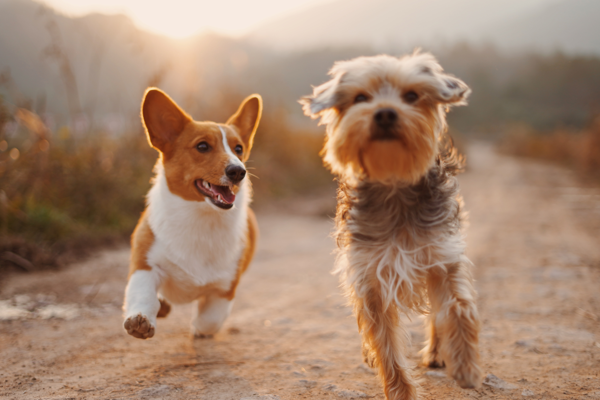

99.55%: Pembroke, Pembroke Welsh corgi
99.26%: Yorkshire terrier
98.92%: Australian terrier
98.54%: Cardigan, Cardigan Welsh corgi
98.09%: silky terrier, Sydney silky


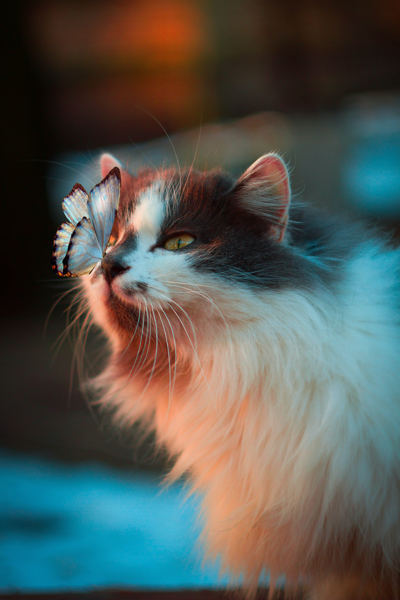

99.59%: Persian cat
97.97%: Egyptian cat
97.66%: Angora, Angora rabbit
96.44%: doormat, welcome mat
96.06%: tabby, tabby cat


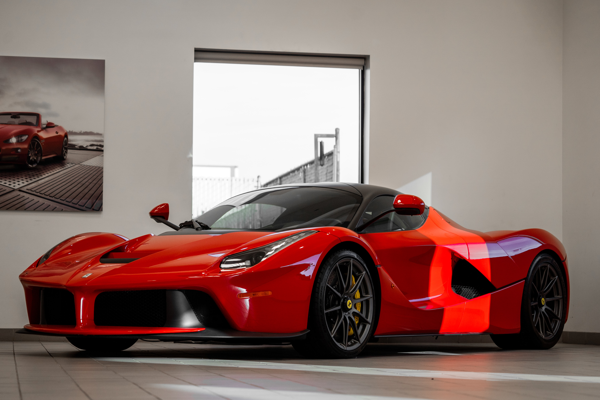

99.82%: sports car, sport car
99.70%: racer, race car, racing car
98.63%: car wheel
92.58%: grille, radiator grille
86.70%: convertible


In [10]:
for url in urls:
    img, tensor = load_img(url)
    
    display(img.resize((int(x*600/max(img.size)) for x in img.size)))
    eval(tensor)